# Imports

In [37]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Data importing and pre-processing

In [38]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(60, 1,64, 64, 1)

labels = np.zeros(60)

x_real_train, x_real_test = train_test_split(df, test_size=0.2) #12 test values
y_real_train, y_real_test = train_test_split(labels, test_size=0.2)

normalize dataset data into range of tanh (-1,1)

In [39]:
x_real_train = x_real_train.astype('float32')
x_real_train /= 255

# Generator Model

Create points in latent space to be fed into generator

In [40]:
def generate_generator_input():
    input = np.random.normal(50,2,size=(1,100))
    input = input * 10
    

    
    return input

In [41]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(60*8*8, input_shape=(100,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,60)))

    model.add(Dropout(0.3))

    
    model.add(Conv2DTranspose(128, (1,1), strides=(2,2), padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dropout(0.3))

  
    
    model.add(Conv2DTranspose(64, (1,1), strides=(2,2), padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dropout(0.3))


    model.add(Conv2DTranspose(1, (1,1), strides=(2,2), padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(Activation("tanh"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [42]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(256, (5,5), strides=(2,2), padding="same", input_shape=(64,64,1)))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(Dropout(0.3))
   
    model.add(Conv2D(2048, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(Dropout(0.3))
  
    
    # output layer
    model.add(Flatten())
    
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('tanh'))
    
    model.summary()
    return model
    

# Training

First, create the models from the functions

In [43]:
gen_model = make_generator()

noise = generate_generator_input()
test_gen = gen_model(noise, training = False)

print(test_gen)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3840)              387840    
                                                                 
 batch_normalization_6 (Bat  (None, 3840)              15360     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 3840)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 60)          0         
                                                                 
 dropout_12 (Dropout)        (None, 8, 8, 60)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 128)       7808      
 Transpose)                                           

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

In [44]:
disc_model = make_discriminator()
decision = disc_model(test_gen)
print(decision)

: 

: 

## Loss and Optimizers

In [ ]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, adapted from: https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [ ]:
gen_optimizer = Adam(1e-4)
disc_optimizer = Adam(1e-4)

Discriminator accuracy

In [ ]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output >=0:
        
        if fake_output <0:
            accuracy = (real_output + fake_output) / (real_output + fake_output)
        else:
            accuracy = real_output/ (real_output + fake_output)
    elif fake_output <0:
        accuracy = fake_output / (real_output + fake_output)
    else:
        accuracy = 0/ (real_output + fake_output)
    
    return accuracy

## Training

training parameters:

In [ ]:
N_EPOCHS = 25

VERBOSE = 1


Training step

In [ ]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input()
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [ ]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            map_batch.reshape(1,64,64,1)

            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / 48
        avg_disc_loss = sum(disc_losses_for_epoch) / 48

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))
    
    input_for_map_after_training = generate_generator_input()
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map


Train GAN

In [ ]:
print(x_real_train.shape)

gen_losses, disc_losses, generated_map = train(x_real_train, N_EPOCHS)

# denormalise generated map

generated_map *= 255




generated_map = generated_map.numpy()

generated_map = np.round(generated_map,0)

generated_map = np.reshape(generated_map, (64,64))

print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',')

generated_map = generated_map.tolist()

print(generated_map)


(48, 1, 64, 64, 1)
epoch = 0
generated map shape(1, 64, 64, 1)
generated map shape(1, 64, 64, 1)
Gen loss = tf.Tensor(1.0695251, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.8088169, shape=(), dtype=float32)
epoch = 1
Gen loss = tf.Tensor(1.3128768, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.62668675, shape=(), dtype=float32)
epoch = 2
Gen loss = tf.Tensor(1.3128879, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.6266809, shape=(), dtype=float32)
epoch = 3
Gen loss = tf.Tensor(1.3129724, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.6266429, shape=(), dtype=float32)
epoch = 4
Gen loss = tf.Tensor(1.3130162, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.6266333, shape=(), dtype=float32)
epoch = 5
Gen loss = tf.Tensor(1.3130647, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.62661666, shape=(), dtype=float32)
epoch = 6
Gen loss = tf.Tensor(1.3131012, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.6266024, shape=(), dtype=float32)
epoch = 7
Gen loss = tf.Tensor(1.313

ValueError: Expected 1D or 2D array, got 4D array instead

graphs:

Text(0.5, 0, 'Epoch')

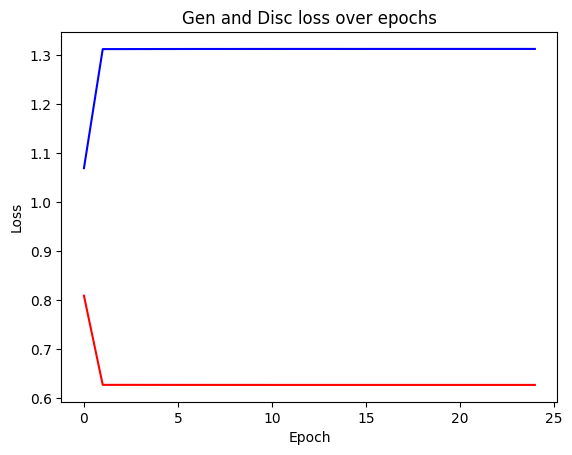

In [ ]:
epoch_list = [i for i in range(0,N_EPOCHS)]



plt.plot(epoch_list,disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')